In [38]:
# Train alternative models on v8 data (largest data set)
# offline, without generating new data
# different models or other hyperparameters for comparison
# without validation games, too costly

# Summarized conclusions:
# - best lr in [1e-4, 1e-3]
# - 1/n decay better than const lr and better than 1/sqrt(n)
# - lr = lr0 * a / (a + n) with a = 250 seems best but is not very sensitive w.r.t. a
# - splitting data into minibatche helps, n_batches = 100 was best out of [1, 10, 100]
# - replay buffer helps, but only recent games seems better (0.02 as exp decay factor)
#   it seems: the more replay the better, that being in all tested (replay games) per (new game)
#   in [0, 1, 2, 4, 8, 10, 20]

In [46]:
import numpy as np
import time
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import sys, os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

from Resources.Model import Model_v4, Model_v5, Model_v6, Model_v7, Model_v8, Model_v9, Model_v10, Model_v11
from Resources.Game import *


ImportError: cannot import name 'Model_v9' from 'Resources.Model' (/Users/Philip/Desktop/GitHub/ChessEngine/Resources/Model.py)

In [3]:
# Get number of training batches
training_data = os.listdir('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8')
i_training_data = 0
while 'inputs_'+str(i_training_data + 1) in training_data:
    i_training_data += 1
n_training_data = i_training_data

In [21]:
n_training_data = 1000

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


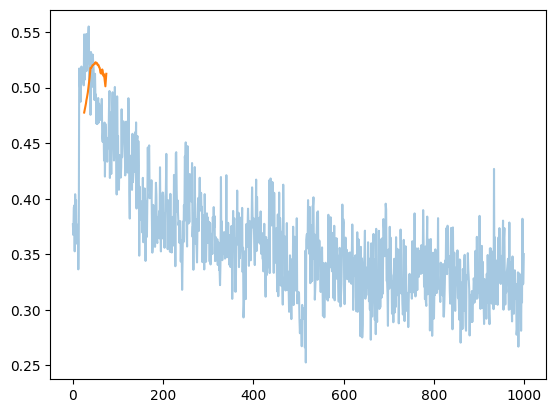

In [22]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 5e-4

error_hist1 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # # get error of new data (without backprop)
    # out = model(inputs_tens)
    # out = out.view(out.shape[0])
    # loss = criterion(out, labels_tens)
    # error_hist.append(loss.item())

    # # load additional older data to replay
    # if batch > 5:
    #     # samples from exp distribution, more recent -> more likely
    #     decay_rate = 0.003
    #     prob =  np.exp(-decay_rate * np.arange(batch)) 
    #     prob = prob/sum(prob)
    #     num_samples = 3
    #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
    #     for index in samples:
    #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
    #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    # inputs_tens = torch.cat(inputs).float() # bool -> float
    # labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        
        error_hist1.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist1, alpha=0.4)
plt.plot(range(25, len(error_hist1) -25 ), [np.mean(error_hist1[i:i+50]) for i in range(len(error_hist1) - 50)])
plt.show()

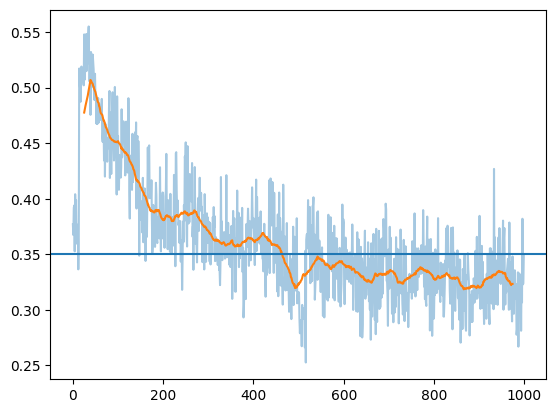

In [25]:
plt.plot(error_hist1, alpha=0.4)
plt.plot(range(25, len(error_hist1) -25 ), [np.mean(error_hist1[i:i+50]) for i in range(len(error_hist1) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

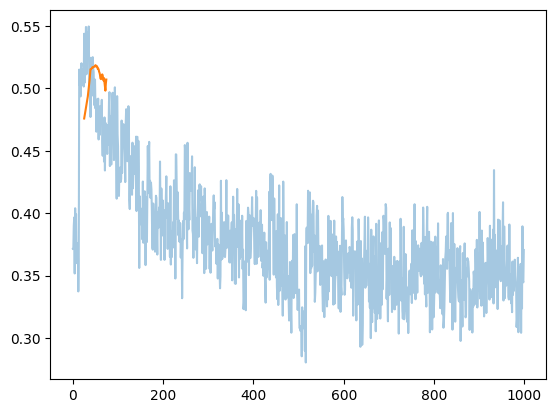

In [23]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 5e-4

error_hist2 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist2.append(loss.item())

    # load additional older data to replay
    if batch > 5 or True:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.003
        prob =  np.exp(-decay_rate * np.arange(batch)) 
        prob = prob/sum(prob)
        num_samples = 10
        samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist2, alpha=0.4)
plt.plot(range(25, len(error_hist2) -25 ), [np.mean(error_hist2[i:i+50]) for i in range(len(error_hist2) - 50)])
plt.show()

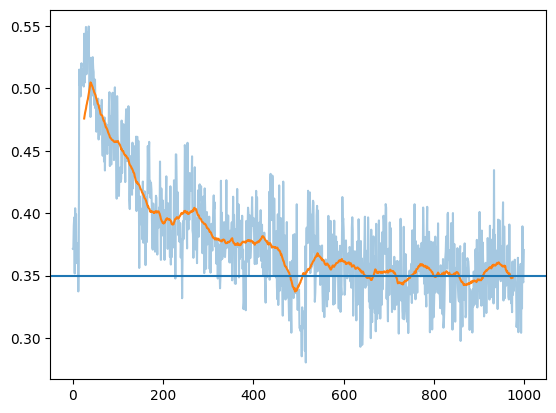

In [24]:

plt.plot(error_hist2, alpha=0.4)
plt.plot(range(25, len(error_hist2) -25 ), [np.mean(error_hist2[i:i+50]) for i in range(len(error_hist2) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

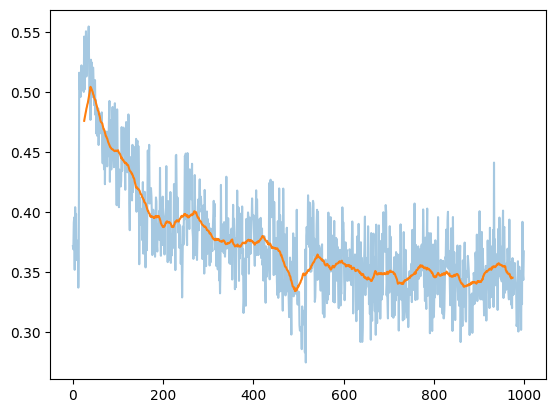

In [41]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 5e-4

error_hist2 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist2.append(loss.item())

    # load additional older data to replay
    if batch > 5 or True:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.03
        prob =  np.exp(-decay_rate * np.arange(batch)) 
        prob = prob/sum(prob)
        num_samples = 5
        samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist2, alpha=0.4)
plt.plot(range(25, len(error_hist2) -25 ), [np.mean(error_hist2[i:i+50]) for i in range(len(error_hist2) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

In [40]:
decay_rate = 0.03
prob =  np.exp(-decay_rate * np.arange(1000)) 
prob = prob/sum(prob)
num_samples = 10
samples = np.random.choice(np.arange(1000, 0, -1), size=num_samples, p=prob)
print(samples)

[984 993 965 969 952 919 981 970 857 933]


training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

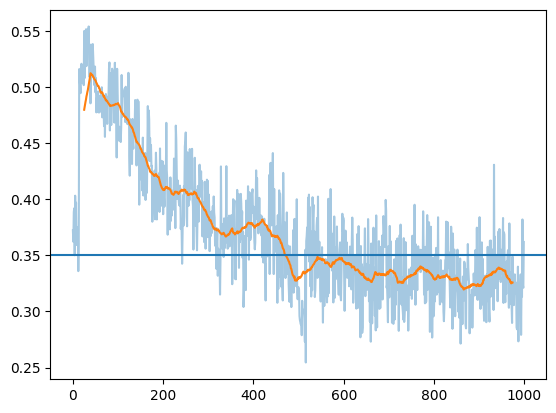

In [42]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 5e-5

error_hist2 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # get error of new data (without backprop)
    out = model(inputs_tens)
    out = out.view(out.shape[0])
    loss = criterion(out, labels_tens)
    error_hist2.append(loss.item())

    # load additional older data to replay
    if batch > 5 or True:
        # samples from exp distribution, more recent -> more likely
        decay_rate = 0.03
        prob =  np.exp(-decay_rate * np.arange(batch)) 
        prob = prob/sum(prob)
        num_samples = 5
        samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
        for index in samples:
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist2, alpha=0.4)
plt.plot(range(25, len(error_hist2) -25 ), [np.mean(error_hist2[i:i+50]) for i in range(len(error_hist2) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

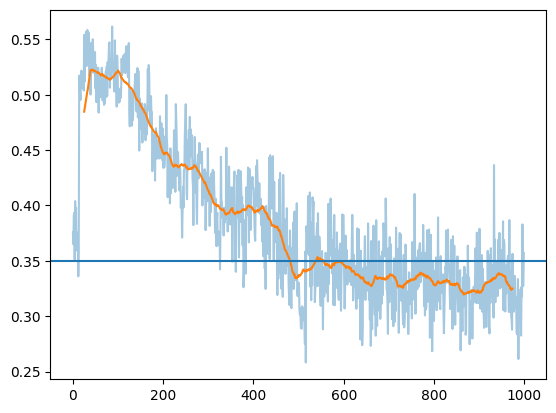

In [43]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 3e-5

error_hist1 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # # get error of new data (without backprop)
    # out = model(inputs_tens)
    # out = out.view(out.shape[0])
    # loss = criterion(out, labels_tens)
    # error_hist.append(loss.item())

    # # load additional older data to replay
    # if batch > 5:
    #     # samples from exp distribution, more recent -> more likely
    #     decay_rate = 0.003
    #     prob =  np.exp(-decay_rate * np.arange(batch)) 
    #     prob = prob/sum(prob)
    #     num_samples = 3
    #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
    #     for index in samples:
    #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
    #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    # inputs_tens = torch.cat(inputs).float() # bool -> float
    # labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        
        error_hist1.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist1, alpha=0.4)
plt.plot(range(25, len(error_hist1) -25 ), [np.mean(error_hist1[i:i+50]) for i in range(len(error_hist1) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

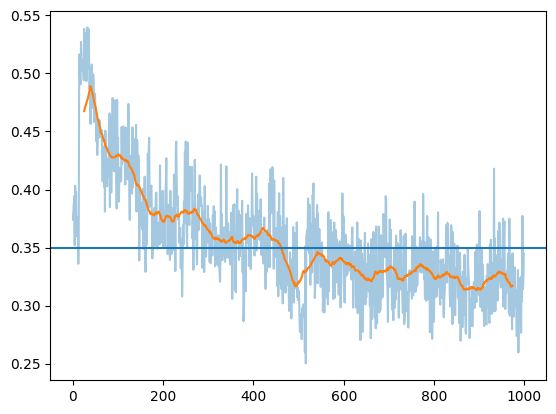

In [44]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 1e-3

error_hist1 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # # get error of new data (without backprop)
    # out = model(inputs_tens)
    # out = out.view(out.shape[0])
    # loss = criterion(out, labels_tens)
    # error_hist.append(loss.item())

    # # load additional older data to replay
    # if batch > 5:
    #     # samples from exp distribution, more recent -> more likely
    #     decay_rate = 0.003
    #     prob =  np.exp(-decay_rate * np.arange(batch)) 
    #     prob = prob/sum(prob)
    #     num_samples = 3
    #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
    #     for index in samples:
    #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
    #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    # inputs_tens = torch.cat(inputs).float() # bool -> float
    # labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        
        error_hist1.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist1, alpha=0.4)
plt.plot(range(25, len(error_hist1) -25 ), [np.mean(error_hist1[i:i+50]) for i in range(len(error_hist1) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

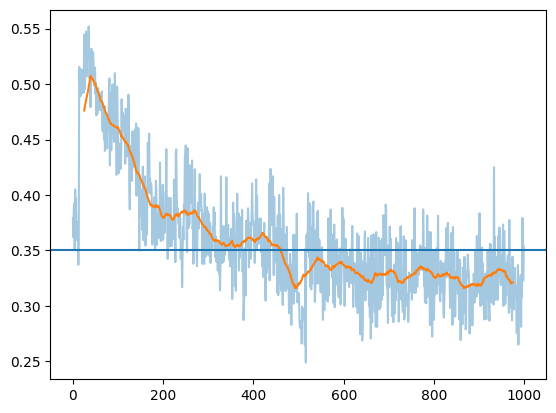

In [45]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 3e-4

error_hist1 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # # get error of new data (without backprop)
    # out = model(inputs_tens)
    # out = out.view(out.shape[0])
    # loss = criterion(out, labels_tens)
    # error_hist.append(loss.item())

    # # load additional older data to replay
    # if batch > 5:
    #     # samples from exp distribution, more recent -> more likely
    #     decay_rate = 0.003
    #     prob =  np.exp(-decay_rate * np.arange(batch)) 
    #     prob = prob/sum(prob)
    #     num_samples = 3
    #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
    #     for index in samples:
    #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
    #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    # inputs_tens = torch.cat(inputs).float() # bool -> float
    # labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=1e-6)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        
        error_hist1.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist1, alpha=0.4)
plt.plot(range(25, len(error_hist1) -25 ), [np.mean(error_hist1[i:i+50]) for i in range(len(error_hist1) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

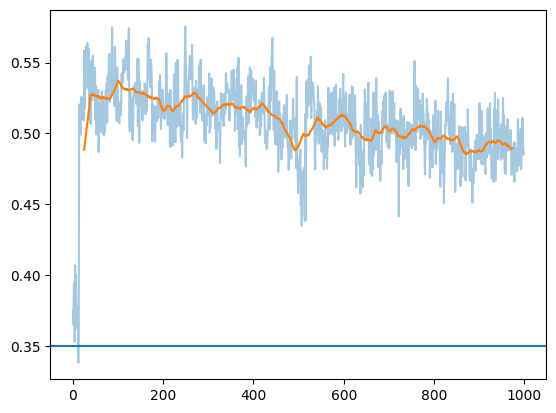

In [49]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 3e-6

error_hist1 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # # get error of new data (without backprop)
    # out = model(inputs_tens)
    # out = out.view(out.shape[0])
    # loss = criterion(out, labels_tens)
    # error_hist.append(loss.item())

    # # load additional older data to replay
    # if batch > 5:
    #     # samples from exp distribution, more recent -> more likely
    #     decay_rate = 0.003
    #     prob =  np.exp(-decay_rate * np.arange(batch)) 
    #     prob = prob/sum(prob)
    #     num_samples = 3
    #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
    #     for index in samples:
    #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
    #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    # inputs_tens = torch.cat(inputs).float() # bool -> float
    # labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        
        error_hist1.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist1, alpha=0.4)
plt.plot(range(25, len(error_hist1) -25 ), [np.mean(error_hist1[i:i+50]) for i in range(len(error_hist1) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

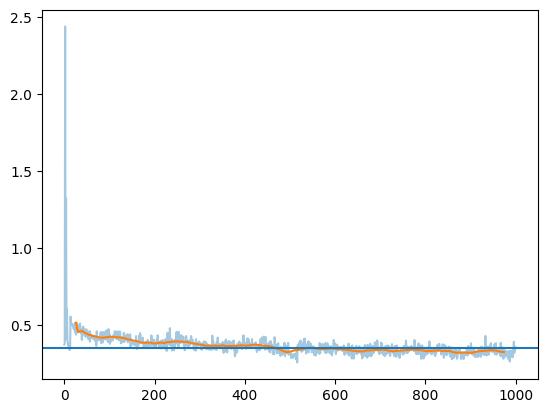

In [50]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 3e-3

error_hist1 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # # get error of new data (without backprop)
    # out = model(inputs_tens)
    # out = out.view(out.shape[0])
    # loss = criterion(out, labels_tens)
    # error_hist.append(loss.item())

    # # load additional older data to replay
    # if batch > 5:
    #     # samples from exp distribution, more recent -> more likely
    #     decay_rate = 0.003
    #     prob =  np.exp(-decay_rate * np.arange(batch)) 
    #     prob = prob/sum(prob)
    #     num_samples = 3
    #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
    #     for index in samples:
    #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
    #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    # inputs_tens = torch.cat(inputs).float() # bool -> float
    # labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        
        error_hist1.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist1, alpha=0.4)
plt.plot(range(25, len(error_hist1) -25 ), [np.mean(error_hist1[i:i+50]) for i in range(len(error_hist1) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

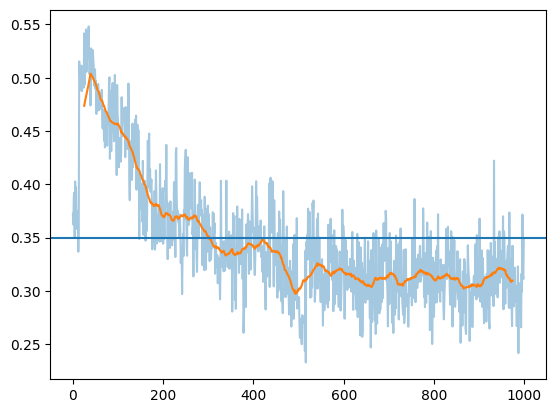

In [51]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 3e-4 * 100 / (100 + batch)

error_hist1 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # # get error of new data (without backprop)
    # out = model(inputs_tens)
    # out = out.view(out.shape[0])
    # loss = criterion(out, labels_tens)
    # error_hist.append(loss.item())

    # # load additional older data to replay
    # if batch > 5:
    #     # samples from exp distribution, more recent -> more likely
    #     decay_rate = 0.003
    #     prob =  np.exp(-decay_rate * np.arange(batch)) 
    #     prob = prob/sum(prob)
    #     num_samples = 3
    #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
    #     for index in samples:
    #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
    #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    # inputs_tens = torch.cat(inputs).float() # bool -> float
    # labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        
        error_hist1.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist1, alpha=0.4)
plt.plot(range(25, len(error_hist1) -25 ), [np.mean(error_hist1[i:i+50]) for i in range(len(error_hist1) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

training batch  10
training batch  20
training batch  30
training batch  40
training batch  50
training batch  60
training batch  70
training batch  80
training batch  90
training batch  100
training batch  110
training batch  120
training batch  130
training batch  140
training batch  150
training batch  160
training batch  170
training batch  180
training batch  190
training batch  200
training batch  210
training batch  220
training batch  230
training batch  240
training batch  250
training batch  260
training batch  270
training batch  280
training batch  290
training batch  300
training batch  310
training batch  320
training batch  330
training batch  340
training batch  350
training batch  360
training batch  370
training batch  380
training batch  390
training batch  400
training batch  410
training batch  420
training batch  430
training batch  440
training batch  450
training batch  460
training batch  470
training batch  480
training batch  490
training batch  500
training 

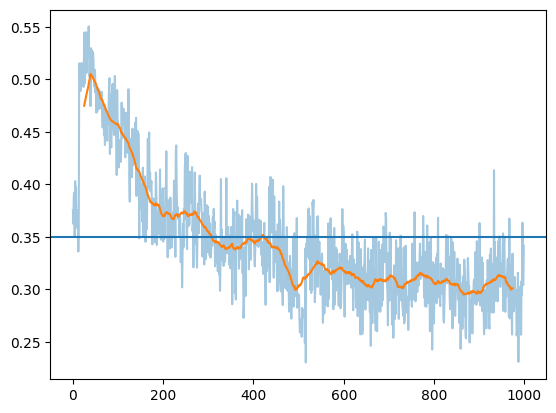

In [52]:
model = Model_v8()
criterion = nn.MSELoss()
n_minibatch = 1
def learning_rate(batch):
    return 3e-4 * 300 / (300 + batch)

error_hist1 = []

for batch in range(1, n_training_data + 1):

    # load all new data
    inputs = []
    labels = []
    for index in range(batch, batch + 1):
        inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    inputs_tens = torch.cat(inputs).float() # bool -> float
    labels_tens = torch.cat(labels)

    # # get error of new data (without backprop)
    # out = model(inputs_tens)
    # out = out.view(out.shape[0])
    # loss = criterion(out, labels_tens)
    # error_hist.append(loss.item())

    # # load additional older data to replay
    # if batch > 5:
    #     # samples from exp distribution, more recent -> more likely
    #     decay_rate = 0.003
    #     prob =  np.exp(-decay_rate * np.arange(batch)) 
    #     prob = prob/sum(prob)
    #     num_samples = 3
    #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
    #     for index in samples:
    #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
    #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

    # inputs_tens = torch.cat(inputs).float() # bool -> float
    # labels_tens = torch.cat(labels)

    if batch % 10 == 0:
        print('training batch ', batch)

    t0 = time.time()

    # training step
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate(batch), weight_decay=0)

    # shuffle data and make mini batches
    indices = torch.randperm(len(inputs_tens))
    inputs_tens = inputs_tens[indices]
    labels_tens = labels_tens[indices]

    batch_size = len(inputs_tens) // n_minibatch

    inputs_loader = inputs_tens.split(batch_size)
    labels_loader = labels_tens.split(batch_size)

    for inputs, labels in zip(inputs_loader, labels_loader):

        out = model(inputs)
        out = out.view(out.shape[0])
        loss = criterion(out, labels)
        
        error_hist1.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

plt.plot(error_hist1, alpha=0.4)
plt.plot(range(25, len(error_hist1) -25 ), [np.mean(error_hist1[i:i+50]) for i in range(len(error_hist1) - 50)])
plt.axhline(0.35, xmin=0, xmax=1000)
plt.show()

In [9]:
def lr_decay(lr0, a, batch):
    return lr0 * a / (a + batch) 

lr0_list            = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2]
a_list              = [20, 50, 100, 250, 750]
weight_decay_list   = [1e-2, 1e-4, 1e-6, 1e-8, 1e-10]

### Learning Rate Comparison

lr =  1e-06 training batch  100
lr =  1e-06 training batch  200
lr =  1e-06 training batch  300
lr =  1e-06 training batch  400
lr =  1e-06 training batch  500
lr =  1e-06 training batch  600
lr =  1e-06 training batch  700
lr =  1e-06 training batch  800
lr =  1e-06 training batch  900
lr =  3e-06 training batch  100
lr =  3e-06 training batch  200
lr =  3e-06 training batch  300
lr =  3e-06 training batch  400
lr =  3e-06 training batch  500
lr =  3e-06 training batch  600
lr =  3e-06 training batch  700
lr =  3e-06 training batch  800
lr =  3e-06 training batch  900
lr =  1e-05 training batch  100
lr =  1e-05 training batch  200
lr =  1e-05 training batch  300
lr =  1e-05 training batch  400
lr =  1e-05 training batch  500
lr =  1e-05 training batch  600
lr =  1e-05 training batch  700
lr =  1e-05 training batch  800
lr =  1e-05 training batch  900
lr =  3e-05 training batch  100
lr =  3e-05 training batch  200
lr =  3e-05 training batch  300
lr =  3e-05 training batch  400
lr =  3e

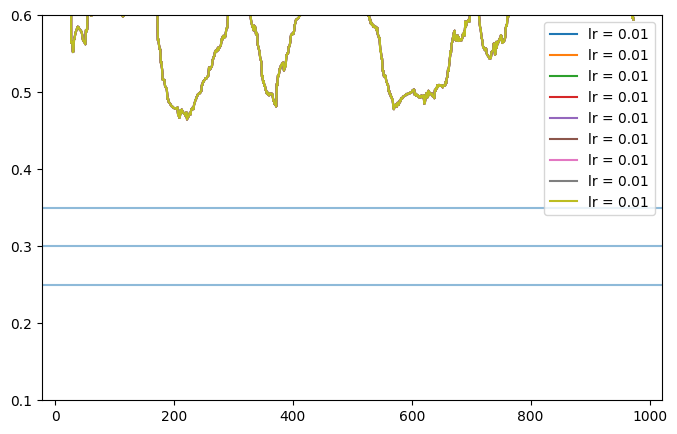

In [59]:
error_hist_tot = []

for lr0 in lr0_list:

    model = Model_v8()
    criterion = nn.MSELoss()

    error_hist_curr = []

    for batch in range(1, 1000):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        # # get error of new data (without backprop)
        # out = model(inputs_tens)
        # out = out.view(out.shape[0])
        # loss = criterion(out, labels_tens)
        # error_hist.append(loss.item())

        # # load additional older data to replay
        # if batch > 5:
        #     # samples from exp distribution, more recent -> more likely
        #     decay_rate = 0.003
        #     prob =  np.exp(-decay_rate * np.arange(batch)) 
        #     prob = prob/sum(prob)
        #     num_samples = 3
        #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
        #     for index in samples:
        #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        # inputs_tens = torch.cat(inputs).float() # bool -> float
        # labels_tens = torch.cat(labels)

        if batch % 100 == 0:
            print('lr = ', lr0, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=lr0, weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) # // n_minibatch

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # plt.plot(error_hist1, alpha=0.4)

    error_hist_tot.append(error_hist_curr)

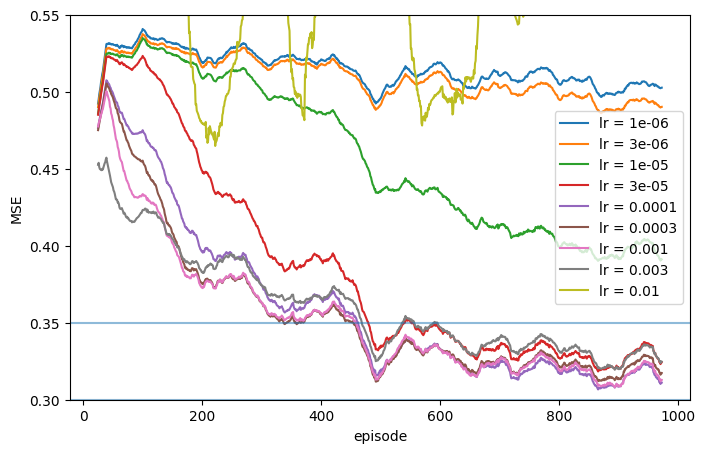

In [65]:
plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot):
    plt.plot(range(25, len(error_hist) -25 ), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='lr = '+str(lr0_list[e]))

plt.legend()
plt.ylim([0.3, 0.55])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

In [ ]:
# chose lr roughly in [1e-4, 1e-3]
# For lr decay analysis start a bit above the higher end of this

### Learning Rate Decay Speed Comparison

In [68]:
error_hist_tot_decay = []

lr0 = 1.5e-3
for a in a_list:

    model = Model_v8()
    criterion = nn.MSELoss()

    error_hist_curr_decay = []

    for batch in range(1, 1000):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        # # get error of new data (without backprop)
        # out = model(inputs_tens)
        # out = out.view(out.shape[0])
        # loss = criterion(out, labels_tens)
        # error_hist.append(loss.item())

        # # load additional older data to replay
        # if batch > 5:
        #     # samples from exp distribution, more recent -> more likely
        #     decay_rate = 0.003
        #     prob =  np.exp(-decay_rate * np.arange(batch)) 
        #     prob = prob/sum(prob)
        #     num_samples = 3
        #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
        #     for index in samples:
        #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        # inputs_tens = torch.cat(inputs).float() # bool -> float
        # labels_tens = torch.cat(labels)

        if batch % 100 == 0:
            print('a = ', a, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=lr_decay(lr0, a, batch), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) # // n_minibatch

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_decay.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_decay.append(error_hist_curr_decay)

a =  20 training batch  100
a =  20 training batch  200
a =  20 training batch  300
a =  20 training batch  400
a =  20 training batch  500
a =  20 training batch  600
a =  20 training batch  700
a =  20 training batch  800
a =  20 training batch  900
a =  50 training batch  100
a =  50 training batch  200
a =  50 training batch  300
a =  50 training batch  400
a =  50 training batch  500
a =  50 training batch  600
a =  50 training batch  700
a =  50 training batch  800
a =  50 training batch  900
a =  100 training batch  100
a =  100 training batch  200
a =  100 training batch  300
a =  100 training batch  400
a =  100 training batch  500
a =  100 training batch  600
a =  100 training batch  700
a =  100 training batch  800
a =  100 training batch  900
a =  250 training batch  100
a =  250 training batch  200
a =  250 training batch  300
a =  250 training batch  400
a =  250 training batch  500
a =  250 training batch  600
a =  250 training batch  700
a =  250 training batch  800
a =

In [10]:
plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_decay):
    plt.plot(range(25, len(error_hist) -25 ), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='a = '+str(a_list[e]))

plt.legend()
plt.ylim([0.25, 0.5])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

NameError: name 'error_hist_tot_decay' is not defined

<Figure size 800x500 with 0 Axes>

In [ ]:
# chose lr = 1.5e-3
# and   a = 250 
# so that learning_rate = 1.5e-3 * 250 / (250 + batch)

### L2 Regularisation Comparison

In [7]:
error_hist_tot_L2 = []

lr0 = 1.5e-3
a = 250
for weight_decay in weight_decay_list:

    model = Model_v8()
    criterion = nn.MSELoss()

    error_hist_curr_L2 = []

    for batch in range(1, 1000):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        # # get error of new data (without backprop)
        # out = model(inputs_tens)
        # out = out.view(out.shape[0])
        # loss = criterion(out, labels_tens)
        # error_hist.append(loss.item())

        # # load additional older data to replay
        # if batch > 5:
        #     # samples from exp distribution, more recent -> more likely
        #     decay_rate = 0.003
        #     prob =  np.exp(-decay_rate * np.arange(batch)) 
        #     prob = prob/sum(prob)
        #     num_samples = 3
        #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
        #     for index in samples:
        #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        # inputs_tens = torch.cat(inputs).float() # bool -> float
        # labels_tens = torch.cat(labels)

        if batch % 100 == 0:
            print('weight_decay = ', weight_decay, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()
        optimizer = optim.Adam(model.parameters(), lr=lr_decay(lr0, a, batch), weight_decay=weight_decay)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) # // n_minibatch

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_L2.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_L2.append(error_hist_curr_L2)

weight_decay =  0.01 training batch  100
weight_decay =  0.01 training batch  200
weight_decay =  0.01 training batch  300
weight_decay =  0.01 training batch  400
weight_decay =  0.01 training batch  500
weight_decay =  0.01 training batch  600
weight_decay =  0.01 training batch  700
weight_decay =  0.01 training batch  800
weight_decay =  0.01 training batch  900
weight_decay =  0.0001 training batch  100
weight_decay =  0.0001 training batch  200
weight_decay =  0.0001 training batch  300
weight_decay =  0.0001 training batch  400
weight_decay =  0.0001 training batch  500
weight_decay =  0.0001 training batch  600
weight_decay =  0.0001 training batch  700
weight_decay =  0.0001 training batch  800
weight_decay =  0.0001 training batch  900
weight_decay =  1e-06 training batch  100
weight_decay =  1e-06 training batch  200
weight_decay =  1e-06 training batch  300
weight_decay =  1e-06 training batch  400
weight_decay =  1e-06 training batch  500
weight_decay =  1e-06 training bat

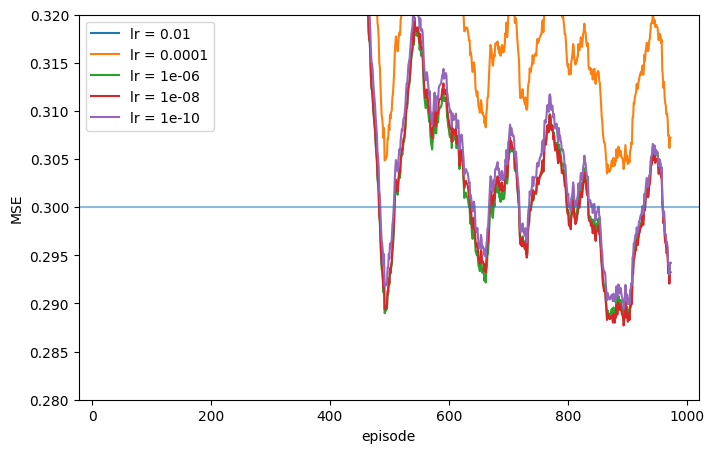

In [9]:
plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_L2):
    plt.plot(range(25, len(error_hist) -25 ), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='lr = '+str(weight_decay_list[e]))

plt.legend()
plt.ylim([0.28, 0.32])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

In [ ]:
# small influence, but small value seems helpful -> weight_decay = 1e-7

### Learning Rate Decay 1/n vs. 1/sqrt(n)

In [12]:
error_hist_tot_mode = []

lr0 = 1.5e-3
a = 250
for mode in range(2):

    model = Model_v8()
    criterion = nn.MSELoss()

    error_hist_curr_mode = []

    for batch in range(1, 1760):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        # # get error of new data (without backprop)
        # out = model(inputs_tens)
        # out = out.view(out.shape[0])
        # loss = criterion(out, labels_tens)
        # error_hist.append(loss.item())

        # # load additional older data to replay
        # if batch > 5:
        #     # samples from exp distribution, more recent -> more likely
        #     decay_rate = 0.003
        #     prob =  np.exp(-decay_rate * np.arange(batch)) 
        #     prob = prob/sum(prob)
        #     num_samples = 3
        #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
        #     for index in samples:
        #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        # inputs_tens = torch.cat(inputs).float() # bool -> float
        # labels_tens = torch.cat(labels)

        if batch % 100 == 0:
            print('mode = ', mode, ' training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        if mode == 0:
            optimizer = optim.Adam(model.parameters(), lr=lr_decay(lr0, a, batch), weight_decay=0)
        if mode == 1:
            optimizer = optim.Adam(model.parameters(), lr=lr0 * np.sqrt( a / (a + batch) ), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) # // n_minibatch

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_mode.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_mode.append(error_hist_curr_mode)

mode =  0  training batch  100
mode =  0  training batch  200
mode =  0  training batch  300
mode =  0  training batch  400
mode =  0  training batch  500
mode =  0  training batch  600
mode =  0  training batch  700
mode =  0  training batch  800
mode =  0  training batch  900
mode =  0  training batch  1000
mode =  0  training batch  1100
mode =  0  training batch  1200
mode =  0  training batch  1300
mode =  0  training batch  1400
mode =  0  training batch  1500
mode =  0  training batch  1600
mode =  0  training batch  1700
mode =  1  training batch  100
mode =  1  training batch  200
mode =  1  training batch  300
mode =  1  training batch  400
mode =  1  training batch  500
mode =  1  training batch  600
mode =  1  training batch  700
mode =  1  training batch  800
mode =  1  training batch  900
mode =  1  training batch  1000
mode =  1  training batch  1100
mode =  1  training batch  1200
mode =  1  training batch  1300
mode =  1  training batch  1400
mode =  1  training batch 

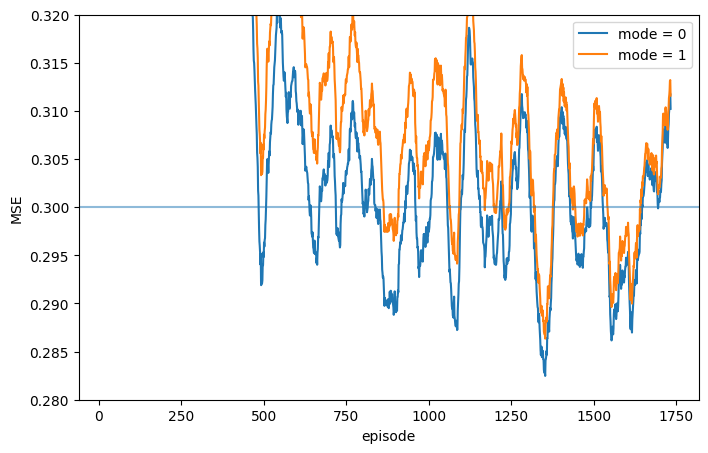

In [13]:
plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_mode):
    plt.plot(range(25, len(error_hist) -25 ), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='mode = '+str(e))

plt.legend()
plt.ylim([0.28, 0.32])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

### Number of Minibatches Comparison

In [10]:
error_hist_tot_batches = []

lr0 = 1.5e-3
a = 250
for n_batches in [1, 10, 100]:

    model = Model_v8()
    criterion = nn.MSELoss()

    error_hist_curr_batches = []

    for batch in range(1, 1760):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        # # get error of new data (without backprop)
        # out = model(inputs_tens)
        # out = out.view(out.shape[0])
        # loss = criterion(out, labels_tens)
        # error_hist.append(loss.item())

        # # load additional older data to replay
        # if batch > 5:
        #     # samples from exp distribution, more recent -> more likely
        #     decay_rate = 0.003
        #     prob =  np.exp(-decay_rate * np.arange(batch)) 
        #     prob = prob/sum(prob)
        #     num_samples = 3
        #     samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
        #     for index in samples:
        #         inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
        #         labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        # inputs_tens = torch.cat(inputs).float() # bool -> float
        # labels_tens = torch.cat(labels)

        if batch % 100 == 0:
            print('minibatches = ', n_batches, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        # if mode == 0:
        #     optimizer = optim.Adam(model.parameters(), lr=lr_decay(lr0, a, batch), weight_decay=0)
        # if mode == 1:
        #     optimizer = optim.Adam(model.parameters(), lr=lr0 * np.sqrt( a / (a + batch) ), weight_decay=0)

        optimizer = optim.Adam(model.parameters(), lr=lr_decay(lr0, a, batch), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_batches.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_batches.append(error_hist_curr_batches)

minibatches =  1 training batch  100
minibatches =  1 training batch  200
minibatches =  1 training batch  300
minibatches =  1 training batch  400
minibatches =  1 training batch  500
minibatches =  1 training batch  600
minibatches =  1 training batch  700
minibatches =  1 training batch  800
minibatches =  1 training batch  900
minibatches =  1 training batch  1000
minibatches =  1 training batch  1100
minibatches =  1 training batch  1200
minibatches =  1 training batch  1300
minibatches =  1 training batch  1400
minibatches =  1 training batch  1500
minibatches =  1 training batch  1600
minibatches =  1 training batch  1700
minibatches =  10 training batch  100
minibatches =  10 training batch  200
minibatches =  10 training batch  300
minibatches =  10 training batch  400
minibatches =  10 training batch  500
minibatches =  10 training batch  600
minibatches =  10 training batch  700
minibatches =  10 training batch  800
minibatches =  10 training batch  900
minibatches =  10 tra

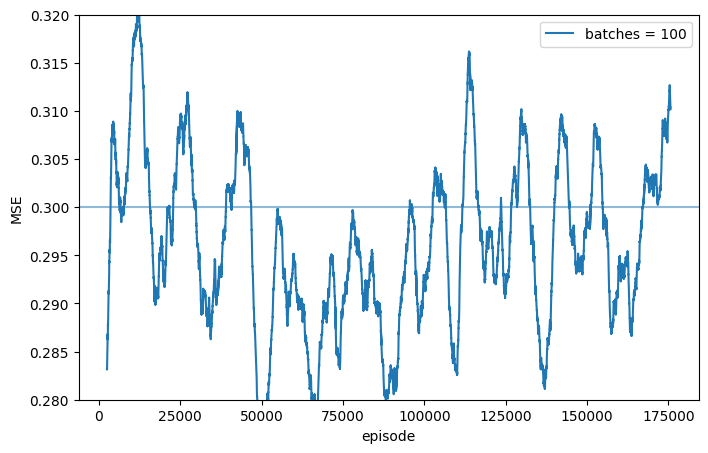

In [18]:
plt.figure(figsize=(8, 5))
# for e, error_hist in enumerate(error_hist_tot_batches):
#     plt.plot(range(25, len(error_hist) -25 ), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='batches = '+str(10**e))

# plt.plot(range(25, len(error_hist_tot_batches[0]) -25 ), [np.mean(error_hist_tot_batches[0][i:i+50]) for i in range(len(error_hist_tot_batches[0]) - 50)], label='batches = 1')
# plt.plot(range(250, len(error_hist_tot_batches[1]) -250 ), [np.mean(error_hist_tot_batches[1][i:i+500]) for i in range(len(error_hist_tot_batches[1]) - 500)], label='batches = 10')
plt.plot(range(2500, len(error_hist_tot_batches[2]) -2500 ), [np.mean(error_hist_tot_batches[2][i:i+5000]) for i in range(len(error_hist_tot_batches[2]) - 5000)], label='batches = 100')

plt.legend()
plt.ylim([0.28, 0.32])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

### Number of replay games per new game

In [12]:
error_hist_tot_replay = []

lr0 = 1.5e-3
a = 250
n_batches = 100
for n_replay in [0, 1, 2, 4, 8]:

    model = Model_v8()
    criterion = nn.MSELoss()

    error_hist_curr_replay = []

    for batch in range(1, 1760):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        # # get error of new data (without backprop)
        # out = model(inputs_tens)
        # out = out.view(out.shape[0])
        # loss = criterion(out, labels_tens)
        # error_hist.append(loss.item())

        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        if batch % 100 == 0:
            print('n_replay = ', n_replay, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // 100 #n_minibatch

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_replay.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_replay.append(error_hist_curr_replay)

n_replay =  0 training batch  100
n_replay =  0 training batch  200
n_replay =  0 training batch  300
n_replay =  0 training batch  400
n_replay =  0 training batch  500
n_replay =  0 training batch  600
n_replay =  0 training batch  700
n_replay =  0 training batch  800
n_replay =  0 training batch  900
n_replay =  0 training batch  1000
n_replay =  0 training batch  1100
n_replay =  0 training batch  1200
n_replay =  0 training batch  1300
n_replay =  0 training batch  1400
n_replay =  0 training batch  1500
n_replay =  0 training batch  1600
n_replay =  0 training batch  1700
n_replay =  1 training batch  100
n_replay =  1 training batch  200
n_replay =  1 training batch  300
n_replay =  1 training batch  400
n_replay =  1 training batch  500
n_replay =  1 training batch  600
n_replay =  1 training batch  700
n_replay =  1 training batch  800
n_replay =  1 training batch  900
n_replay =  1 training batch  1000
n_replay =  1 training batch  1100
n_replay =  1 training batch  1200
n_r

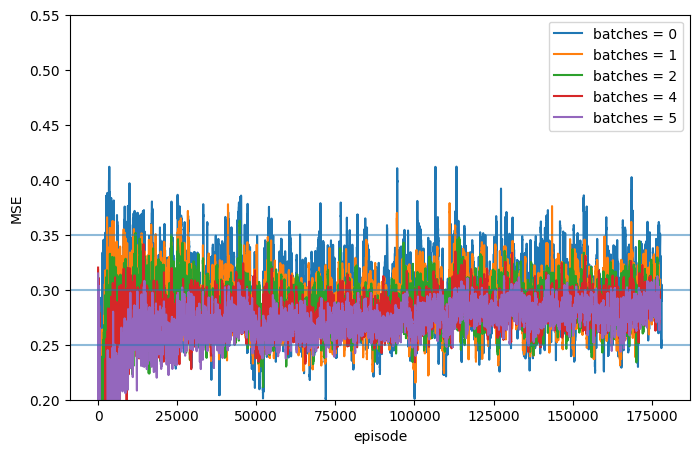

In [19]:
replay_list = [0, 1, 2, 4, 5]

plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_replay):
    plt.plot(range(25, len(error_hist) -25 ), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='batches = '+str(replay_list[e]))

plt.legend()
plt.ylim([0.20, 0.55])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

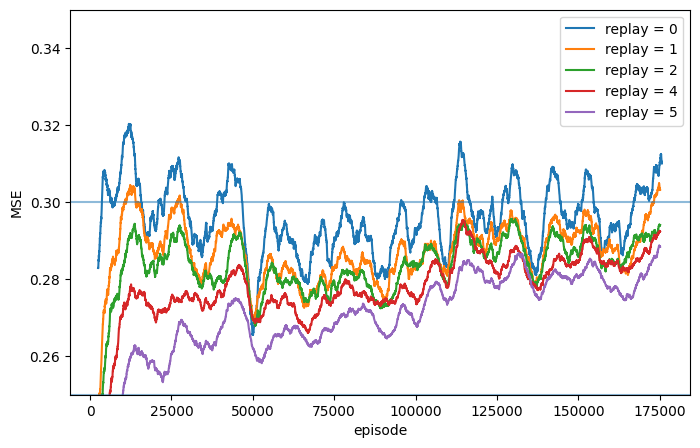

In [20]:
plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_replay):
    plt.plot(range(2500, len(error_hist) -2500 ), [np.mean(error_hist[i:i+5000]) for i in range(len(error_hist) - 5000)], label='replay = '+str(replay_list[e]))

plt.legend()
plt.ylim([0.25, 0.35])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

In [ ]:
# More replay (recent replay for non-stationary env) -> better

In [21]:
error_hist_tot_replay2 = []

lr0 = 1.5e-3
a = 250
n_batches = 100
for n_replay in [10, 20]:

    model = Model_v8()
    criterion = nn.MSELoss()

    error_hist_curr_replay2 = []

    for batch in range(1, 500):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        # get error of new data (without backprop)
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_replay2.append(loss.item())

        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)

        if batch % 100 == 0:
            print('n_replay = ', n_replay, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // 100 #n_minibatch

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            # error_hist_curr_replay2.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_replay2.append(error_hist_curr_replay2)

n_replay =  10 training batch  100
n_replay =  10 training batch  200
n_replay =  10 training batch  300
n_replay =  10 training batch  400
n_replay =  20 training batch  100
n_replay =  20 training batch  200
n_replay =  20 training batch  300
n_replay =  20 training batch  400


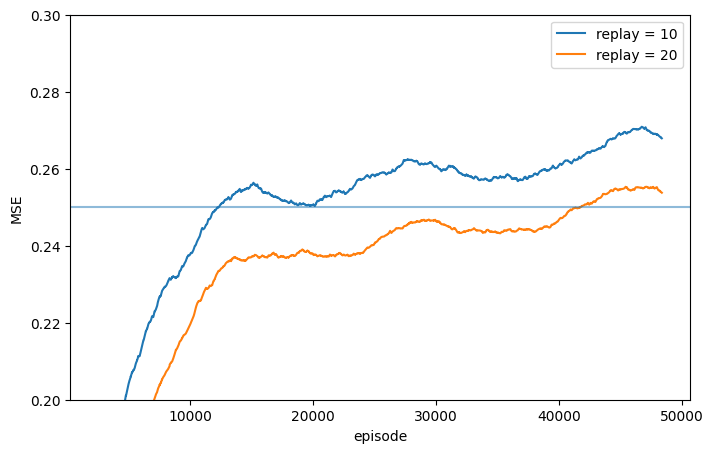

In [24]:
plt.figure(figsize=(8, 5))

plt.plot(range(2500, len(error_hist_tot_replay2[0]) - 2500 ), [np.mean(error_hist_tot_replay2[0][i:i+5000]) for i in range(len(error_hist_tot_replay2[0]) - 5000)], label='replay = 10')
plt.plot(range(2500, len(error_hist_tot_replay2[1]) - 2500 ), [np.mean(error_hist_tot_replay2[1][i:i+5000]) for i in range(len(error_hist_tot_replay2[1]) - 5000)], label='replay = 20')


plt.legend()
plt.ylim([0.20, 0.30])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

In [ ]:
# Again confirmed: 
# More replay (recent replay for non-stationary env) -> better

### Model Architecture Comparison

In [35]:
error_hist_tot_models = []

lr0 = 1.5e-3
a = 250
n_batches = 1
n_replay = 0    # replay helps, but takes too long here

for model_ind in [4, 5, 6, 7, 8]:

    print(' -- model: ', model_ind)

    if model_ind == 4:
        model = Model_v4()
    if model_ind == 5:
        model = Model_v5()
    if model_ind == 6:
        model = Model_v6()
    if model_ind == 7:
        model = Model_v7()
    if model_ind == 8:
        model = Model_v8()
    criterion = nn.MSELoss()

    pars = [i for i in model.parameters()]
    print('number of parameters: ', sum(i.numel() for i in model.parameters()))

    error_hist_curr_models = []

    for batch in range(1, 1500):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)


        ''' # -- REPLAY --
        # get error of new data (without backprop)
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)
        '''

        if batch % 100 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_models.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_models.append(error_hist_curr_models)

 -- model:  4
number of parameters:  30677
model:  4 training batch  100
model:  4 training batch  200
model:  4 training batch  300
model:  4 training batch  400
model:  4 training batch  500
model:  4 training batch  600
model:  4 training batch  700
model:  4 training batch  800
model:  4 training batch  900
model:  4 training batch  1000
model:  4 training batch  1100
model:  4 training batch  1200
model:  4 training batch  1300
model:  4 training batch  1400
 -- model:  5
number of parameters:  221345
model:  5 training batch  100
model:  5 training batch  200
model:  5 training batch  300
model:  5 training batch  400
model:  5 training batch  500
model:  5 training batch  600
model:  5 training batch  700
model:  5 training batch  800
model:  5 training batch  900
model:  5 training batch  1000
model:  5 training batch  1100
model:  5 training batch  1200
model:  5 training batch  1300
model:  5 training batch  1400
 -- model:  6
number of parameters:  83233
model:  6 training b

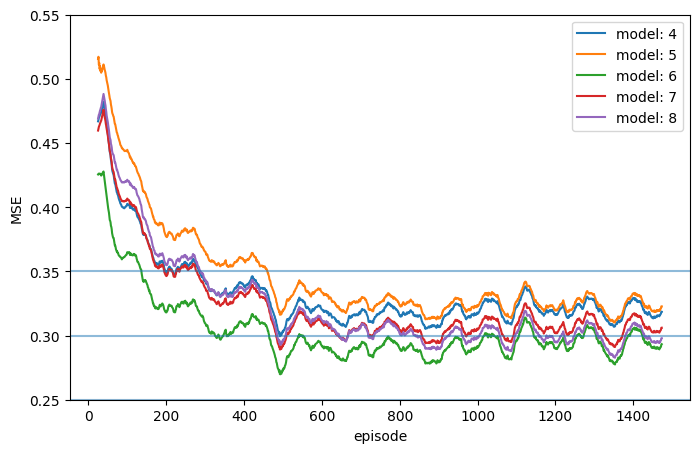

In [36]:
models = [4, 5, 6, 7, 8]

plt.figure(figsize=(8, 5))
for e, error_hist in enumerate(error_hist_tot_models):
    plt.plot(range(25, len(error_hist) - 25), [np.mean(error_hist[i:i+50]) for i in range(len(error_hist) - 50)], label='model: '+str(models[e]))

plt.legend()
plt.ylim([0.25, 0.55])
plt.axhline(0.35, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.30, xmin=0, xmax=1000, alpha=0.5)
plt.axhline(0.25, xmin=0, xmax=1000, alpha=0.5)
plt.xlabel('episode')
plt.ylabel('MSE')
plt.show()

In [ ]:
# Best model: 6 (fully connected one, no convs)
# meets limitation quickly
# model 5: big but pooling -> bad -> dont use pooling
# model 4: very small

# Best model apart from 6: 8
# converges slowly, but best long term behavior

# Next test: is even bigger model even better?
# model 9: wider model
# model 10: deeper model
# model 11: wider as well as deeper

In [ ]:
error_hist_tot_models = []

lr0 = 1.5e-3
a = 250
n_batches = 1
n_replay = 0    # replay helps, but takes too long here

for model_ind in [8, 9, 10, 11]:

    print(' -- model: ', model_ind)

    if model_ind == 8:
        model = Model_v8()
    if model_ind == 9:
        model = Model_v9()
    if model_ind == 10:
        model = Model_v10()
    if model_ind == 11:
        model = Model_v11()
    criterion = nn.MSELoss()

    pars = [i for i in model.parameters()]
    print('number of parameters: ', sum(i.numel() for i in model.parameters()))

    error_hist_curr_models = []

    for batch in range(1, 1500):#n_training_data + 1):

        # load all new data
        inputs = []
        labels = []
        for index in range(batch, batch + 1):
            inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
            labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)


        ''' # -- REPLAY --
        # get error of new data (without backprop)
        out = model(inputs_tens)
        out = out.view(out.shape[0])
        loss = criterion(out, labels_tens)
        error_hist_curr_models.append(loss.item())
        
        # load additional older data to replay
        if batch > 5:
            # samples from exp distribution, more recent -> more likely
            decay_rate = 0.02
            prob =  np.exp(-decay_rate * np.arange(batch)) 
            prob = prob/sum(prob)
            num_samples = n_replay
            samples = np.random.choice(np.arange(batch, 0, -1), size=num_samples, p=prob)
            for index in samples:
                inputs.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/inputs_{}'.format(index)))
                labels.append(torch.load('/Users/Philip/Desktop/Projects/RL Chess/MCTS/Game Saves v8/labels_{}'.format(index)))

        inputs_tens = torch.cat(inputs).float() # bool -> float
        labels_tens = torch.cat(labels)
        '''

        if batch % 100 == 0:
            print('model: ', model_ind, 'training batch ', batch)

        t0 = time.time()

        # training step
        model.train()

        optimizer = optim.Adam(model.parameters(), lr=lr0 * a / (a + batch), weight_decay=0)

        # shuffle data and make mini batches
        indices = torch.randperm(len(inputs_tens))
        inputs_tens = inputs_tens[indices]
        labels_tens = labels_tens[indices]

        batch_size = len(inputs_tens) // n_batches

        inputs_loader = inputs_tens.split(batch_size)
        labels_loader = labels_tens.split(batch_size)

        for inputs, labels in zip(inputs_loader, labels_loader):

            out = model(inputs)
            out = out.view(out.shape[0])
            loss = criterion(out, labels)
            
            error_hist_curr_models.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    error_hist_tot_models.append(error_hist_curr_models)

In [42]:
for model_ind in [8, 9, 10, 11]:

    print(' -- model: ', model_ind)

    if model_ind == 8:
        model = Model_v8()
    if model_ind == 9:
        model = Model_v9()
    if model_ind == 10:
        model = Model_v10()
    if model_ind == 11:
        model = Model_v11()
    criterion = nn.MSELoss()

    pars = [i for i in model.parameters()]
    print('number of parameters: ', sum(i.numel() for i in model.parameters()))

 -- model:  8
number of parameters:  2188757
 -- model:  9


NameError: name 'Model_v9' is not defined